# Importation des libraries

In [19]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import seaborn as sns
import pandas as pd 
import random
import math
from scipy.stats import expon
import time
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator 
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from pandas import read_csv
from pandas.plotting import autocorrelation_plot
import scipy.optimize as optim

#from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
plt.style.use('seaborn')
%matplotlib inline 

# Lecture et Preparation des donnees

Nous proposons une modelisation des cas confirmes par jour et des cas confirmes cumulatif

In [20]:
#df = pd.read_csv("https://raw.githubusercontent.com/maelfabien/COVID-19-Senegal/master/COVID_Dakar.csv",sep=";" )
#df.tail()
#df = pd.read_csv("COVID_Senegal.csv",sep=";" )
#print(df.head())
#confirmed_df = df[df['Positif']==1]
#confirmed = confirmed_df[['Date', 'Positif']]
#confirmed_cases= confirmed[['Date', 'Positif']].groupby("Date").sum()

#deaths_df = df[df['Décédé']==1]
#deaths = deaths_df[['Date', 'Décédé']]
#deaths_cases= deaths[['Date', 'Décédé']].groupby("Date").sum()

#recoveries_df = df[df['Guéri']==1]
#recoveries = recoveries_df[['Date', 'Guéri']]
#recoveries_cases= recoveries[['Date', 'Guéri']].groupby("Date").sum()


#negatif_df = df[df['Negatif']==1  ]
#negatif = negatif_df[['Date', 'Negatif']]
#negatif_cases=negatif[['Date', 'Negatif']].groupby("Date").sum()


#len(confirmed_cases)

In [21]:
df = pd.read_csv("dailycasenumber_oa.csv",sep=",")
df.columns


Index(['Country', 'Lat', 'Long', 'Date', 'Confirmed_cases', 'Dead',
       'Recovered', 'Daily_case'],
      dtype='object')

In [33]:
senegal_df = df[df['Country']=='Senegal']
senegal_df.columns
confirmed = senegal_df[['Date', 'Daily_case']]
#confirmed_cases= confirmed[['Date', 'Daily_case']].groupby("Date").sum()

#confirmed
senegal_df[senegal_df['Confirmed_cases'] != 0]['Date'].values[0]


'2020-03-02'

In [23]:
confirmed['Date'].unique()
confirmed_cases1 = confirmed[41:len(confirmed)]
# set column 'Name' as the index of the Dataframe
confirmed_cases = confirmed_cases1.set_index('Date')

#confirmed_cases


Nous travaillons avec les deux jeux de donnees : 
    
    data_each_day :  Nombre de cas confirmes par jour
    data_cum    : Nombre de cas cumules    

In [24]:
data_each_day =  confirmed_cases
data_cum      = confirmed_cases.cumsum() 

# Modelisation 

##  Preparation des donnees

### Donnees journalieres

In [25]:
days_since_each = np.array([i for i in range(len(data_each_day))]).reshape(-1, 1)
cases_each = np.array(data_each_day).reshape(-1, 1)


### Donnees cumulees

In [26]:
days_since_cum = np.array([i for i in range(len(data_cum))]).reshape(-1, 1)
cases_cum = np.array(data_cum).reshape(-1, 1)
len(cases_cum)

29

### Temps predictif

In [27]:
n = 30  # Nombre de jours de predictions
days_in_future = n
future_forcast = np.array([i for i in range(len(confirmed_cases)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-n]

In [39]:
start_date = pd.to_datetime('2020-03-02')   # date debut de l'epidemie
#start_date = datetime.datetime.strptime(start, '%d/%m/%Y')
print(start_date)
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%d/%m/%Y'))
    

2020-03-02 00:00:00


### Split Data set train and Test

#### Donnees journalieres

In [10]:
X_train_each, X_test_each, y_train_each, y_test_each = train_test_split(days_since_each, cases_each, test_size=0.25, shuffle=False) 

#### Donnees cumulees

In [11]:
X_train_cum, X_test_cum, y_train_cum, y_test_cum = train_test_split(days_since_cum, cases_cum, test_size=0.25, shuffle=False) 

# Bayesian Ridge

la régression linéaire bayésien est une méthode de régression linéaire dans laquelle 
l'analyse statistique est réalisée dans le cadre de l'inférence bayésienne . 
Lorsque le modèle de régression a des erreurs qui ont une distribution normale , 
et si une forme particulière de la distribution préalable suppose, les résultats explicites sont disponibles
pour les distributions de probabilité postérieure des paramètres du modèle.

https://fr.qwe.wiki/wiki/Bayesian_linear_regression

##### initialisation et fitting du modele

In [12]:
# bayesian ridge 
tol = [1e-4, 1e-3, 1e-2]
alpha_1 = [1e-7, 1e-6, 1e-5, 1e-4]
alpha_2 = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4]

bayesian_grid = {'tol': tol, 'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 'lambda_2' : lambda_2}

bayesian = BayesianRidge(compute_score=True)
bayesian_search = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)


### donnees journalieres

In [13]:
bayesian_search.fit(X_train_each, y_train_each)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    2.8s finished
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=BayesianRidge(alpha_1=1e-06, alpha_2=1e-06,
                                           compute_score=True, copy_X=True,
                                           fit_intercept=True, lambda_1=1e-06,
                                           lambda_2=1e-06, n_iter=300,
                                           normalize=False, tol=0.001,
                                           verbose=False),
                   iid='warn', n_iter=40, n_jobs=-1,
                   param_distributions={'alpha_1': [1e-07, 1e-06, 1e-05,
                                                    0.0001],
                                        'alpha_2': [1e-07, 1e-06, 1e-05,
                                                    0.0001],
                                        'lambda_1': [1e-07, 1e-06, 1e-05,
                                                     0.0001],
                                        'lambda_2': [1e-

In [15]:
bayesian_search.best_params_

{'tol': 0.01,
 'lambda_2': 0.0001,
 'lambda_1': 1e-07,
 'alpha_2': 1e-05,
 'alpha_1': 0.0001}

In [16]:
bayesian_each = bayesian_search.best_estimator_
each_bayesian_pred = bayesian_each.predict(X_test_each)
print('MAE:', mean_absolute_error(each_bayesian_pred, y_test_each))
print('MSE:',mean_squared_error(each_bayesian_pred, y_test_each))

len(each_bayesian_pred)

MAE: 3.0406289222147302
MSE: 13.551045721798042


7

In [17]:
each_bayesian_pred_future = bayesian_each.predict(future_forcast)
each_bayesian_pred_future

array([-1.76081157, -1.21330184, -0.66579211, -0.11828238,  0.42922734,
        0.97673707,  1.5242468 ,  2.07175653,  2.61926626,  3.16677599,
        3.71428571,  4.26179544,  4.80930517,  5.3568149 ,  5.90432463,
        6.45183436,  6.99934408,  7.54685381,  8.09436354,  8.64187327,
        9.189383  ,  9.73689273, 10.28440246, 10.83191218, 11.37942191,
       11.92693164, 12.47444137, 13.0219511 , 13.56946083, 14.11697055,
       14.66448028, 15.21199001, 15.75949974, 16.30700947, 16.8545192 ,
       17.40202893, 17.94953865, 18.49704838, 19.04455811, 19.59206784,
       20.13957757, 20.6870873 , 21.23459702, 21.78210675, 22.32961648,
       22.87712621, 23.42463594, 23.97214567, 24.51965539, 25.06716512,
       25.61467485, 26.16218458, 26.70969431, 27.25720404, 27.80471377,
       28.35222349, 28.89973322, 29.44724295])

In [18]:
# Future predictions using Linear Regression 
print('Ridge regression future predictions:')
set(zip(future_forcast_dates, np.round(each_bayesian_pred_future) ))

Ridge regression future predictions:


{('01/04/2020', 14.0),
 ('02/04/2020', 15.0),
 ('03/03/2020', -2.0),
 ('03/04/2020', 15.0),
 ('04/03/2020', -1.0),
 ('04/04/2020', 16.0),
 ('05/03/2020', -1.0),
 ('05/04/2020', 16.0),
 ('06/03/2020', -0.0),
 ('06/04/2020', 17.0),
 ('07/03/2020', 0.0),
 ('07/04/2020', 17.0),
 ('08/03/2020', 1.0),
 ('08/04/2020', 18.0),
 ('09/03/2020', 2.0),
 ('09/04/2020', 18.0),
 ('10/03/2020', 2.0),
 ('10/04/2020', 19.0),
 ('11/03/2020', 3.0),
 ('11/04/2020', 20.0),
 ('12/03/2020', 3.0),
 ('12/04/2020', 20.0),
 ('13/03/2020', 4.0),
 ('13/04/2020', 21.0),
 ('14/03/2020', 4.0),
 ('14/04/2020', 21.0),
 ('15/03/2020', 5.0),
 ('15/04/2020', 22.0),
 ('16/03/2020', 5.0),
 ('16/04/2020', 22.0),
 ('17/03/2020', 6.0),
 ('17/04/2020', 23.0),
 ('18/03/2020', 6.0),
 ('18/04/2020', 23.0),
 ('19/03/2020', 7.0),
 ('19/04/2020', 24.0),
 ('20/03/2020', 8.0),
 ('20/04/2020', 25.0),
 ('21/03/2020', 8.0),
 ('21/04/2020', 25.0),
 ('22/03/2020', 9.0),
 ('22/04/2020', 26.0),
 ('23/03/2020', 9.0),
 ('23/04/2020', 26.0),
 ('24

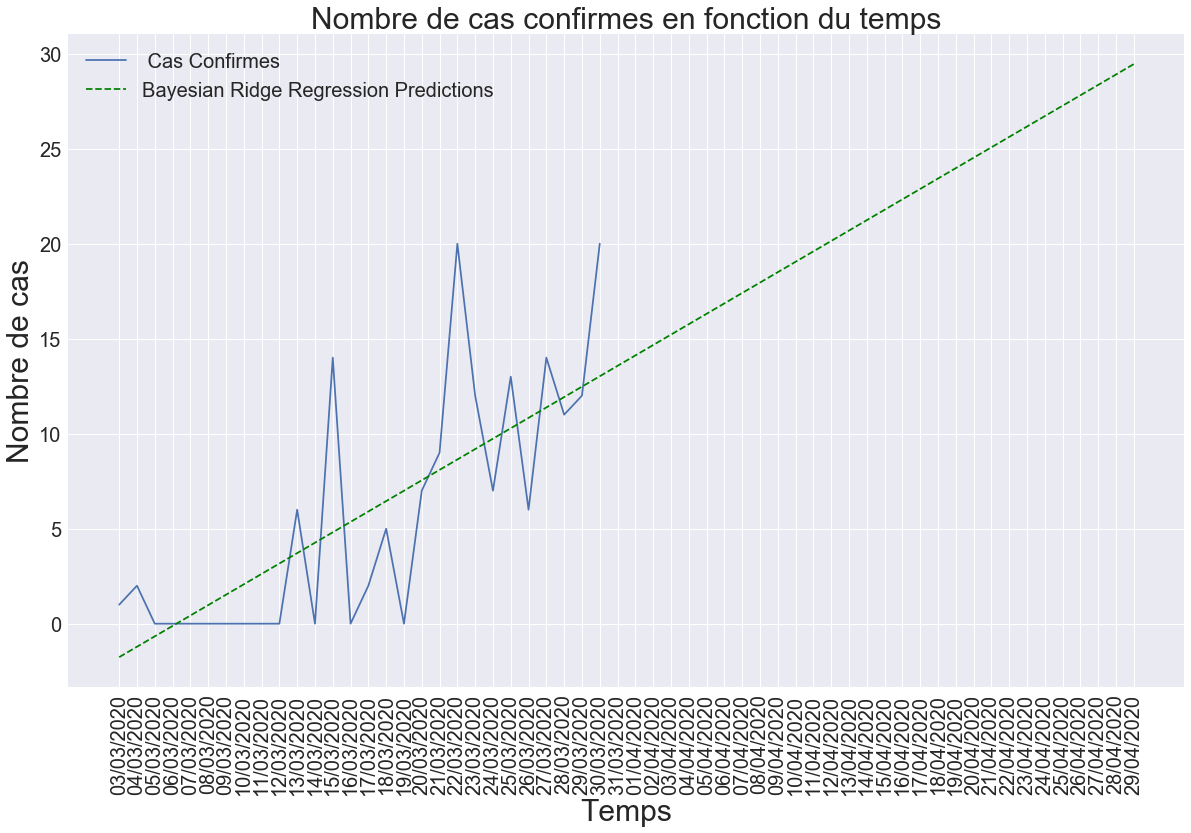

In [19]:
plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, cases_each)
plt.plot(future_forcast_dates, each_bayesian_pred_future, linestyle='dashed', color='green')
plt.title('Nombre de cas confirmes en fonction du temps', size=30)
plt.xlabel('Temps', size=30)
plt.ylabel('Nombre de cas', size=30)
plt.legend([' Cas Confirmes', 'Bayesian Ridge Regression Predictions'], prop={'size': 20})
plt.xticks(size=20, rotation= 90)
plt.yticks(size=20)
plt.show()

#### donnees cumulees

In [20]:
bayesian_search.fit(X_train_cum, y_train_cum)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.2s finished
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=BayesianRidge(alpha_1=1e-06, alpha_2=1e-06,
                                           compute_score=True, copy_X=True,
                                           fit_intercept=True, lambda_1=1e-06,
                                           lambda_2=1e-06, n_iter=300,
                                           normalize=False, tol=0.001,
                                           verbose=False),
                   iid='warn', n_iter=40, n_jobs=-1,
                   param_distributions={'alpha_1': [1e-07, 1e-06, 1e-05,
                                                    0.0001],
                                        'alpha_2': [1e-07, 1e-06, 1e-05,
                                                    0.0001],
                                        'lambda_1': [1e-07, 1e-06, 1e-05,
                                                     0.0001],
                                        'lambda_2': [1e-

In [21]:
bayesian_cum = bayesian_search.best_estimator_
cum_bayesian_pred = bayesian_each.predict(X_test_cum)
print('MAE:', mean_absolute_error(cum_bayesian_pred, y_test_cum))
print('MSE:',mean_squared_error(cum_bayesian_pred, y_test_cum))




MAE: 108.04914951619875
MSE: 12218.461020189867


In [22]:
cum_bayesian_pred_future = bayesian_cum.predict(future_forcast)
len(cum_bayesian_pred_future)

58

In [23]:
# Future predictions using Linear Regression 
print('Ridge regression future predictions:')
set(zip(future_forcast_dates, np.round(cum_bayesian_pred_future) ))


Ridge regression future predictions:


{('01/04/2020', 78.0),
 ('02/04/2020', 81.0),
 ('03/03/2020', -12.0),
 ('03/04/2020', 84.0),
 ('04/03/2020', -8.0),
 ('04/04/2020', 87.0),
 ('05/03/2020', -5.0),
 ('05/04/2020', 90.0),
 ('06/03/2020', -2.0),
 ('06/04/2020', 93.0),
 ('07/03/2020', 1.0),
 ('07/04/2020', 96.0),
 ('08/03/2020', 4.0),
 ('08/04/2020', 99.0),
 ('09/03/2020', 7.0),
 ('09/04/2020', 102.0),
 ('10/03/2020', 10.0),
 ('10/04/2020', 106.0),
 ('11/03/2020', 13.0),
 ('11/04/2020', 109.0),
 ('12/03/2020', 16.0),
 ('12/04/2020', 112.0),
 ('13/03/2020', 19.0),
 ('13/04/2020', 115.0),
 ('14/03/2020', 22.0),
 ('14/04/2020', 118.0),
 ('15/03/2020', 25.0),
 ('15/04/2020', 121.0),
 ('16/03/2020', 28.0),
 ('16/04/2020', 124.0),
 ('17/03/2020', 32.0),
 ('17/04/2020', 127.0),
 ('18/03/2020', 35.0),
 ('18/04/2020', 130.0),
 ('19/03/2020', 38.0),
 ('19/04/2020', 133.0),
 ('20/03/2020', 41.0),
 ('20/04/2020', 136.0),
 ('21/03/2020', 44.0),
 ('21/04/2020', 139.0),
 ('22/03/2020', 47.0),
 ('22/04/2020', 142.0),
 ('23/03/2020', 50.0),

In [ ]:
adjusted_dates
future_forcast_dates[1:len(cases_cum)]
len(cases_cum)

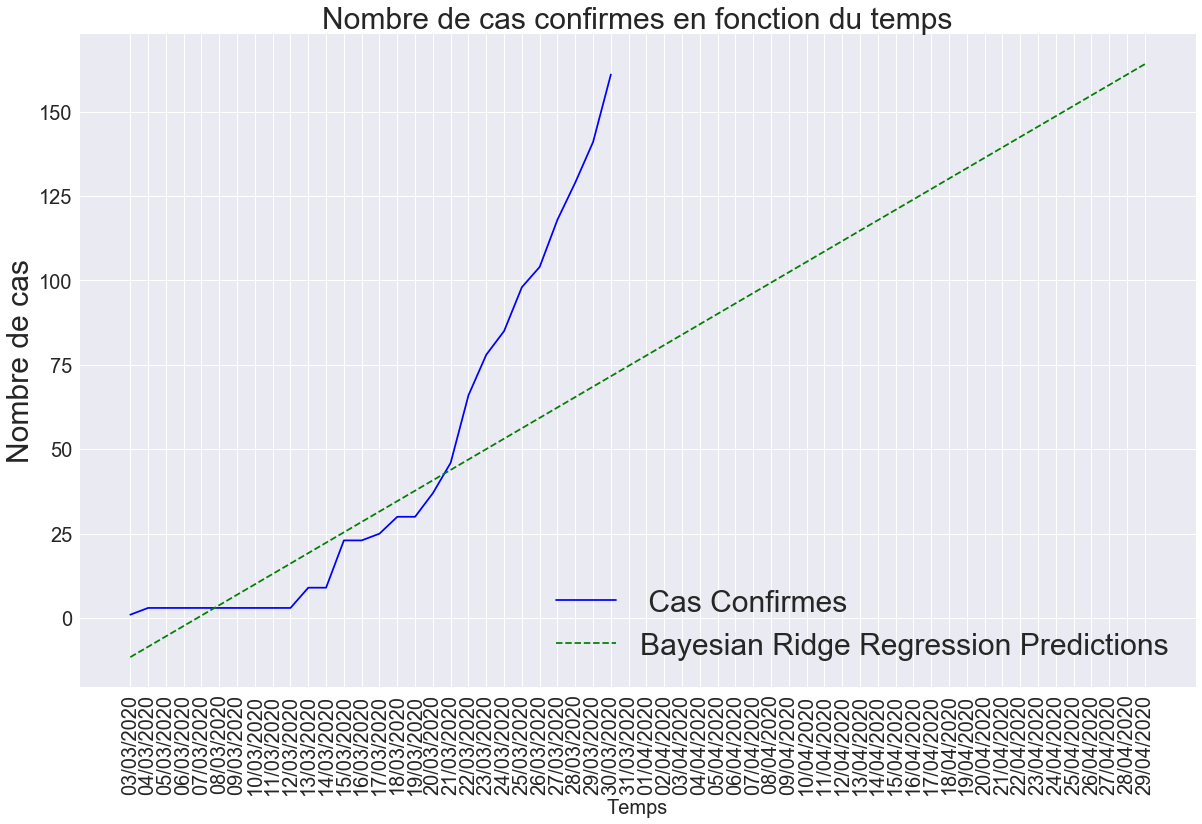

In [24]:
plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, cases_cum, color='blue')
plt.plot(future_forcast_dates, cum_bayesian_pred_future, linestyle='dashed', color='green')
plt.title('Nombre de cas confirmes en fonction du temps', size=30)
plt.xlabel('Temps', size=20)
plt.ylabel('Nombre de cas', size=30)
plt.legend([' Cas Confirmes', 'Bayesian Ridge Regression Predictions'], prop={'size': 30})
plt.xticks(size=20, rotation = 90)
plt.yticks(size=20)
plt.show()

# Polynomial Regression

In [25]:
from sklearn.preprocessing import PolynomialFeatures
p = 2
poly = PolynomialFeatures(degree = p)
X_poly= poly.fit_transform(X_train_cum)
poly.fit(X_poly, y_train_cum)
lin2 = LinearRegression()
lin2.fit(X_poly, y_train_cum)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

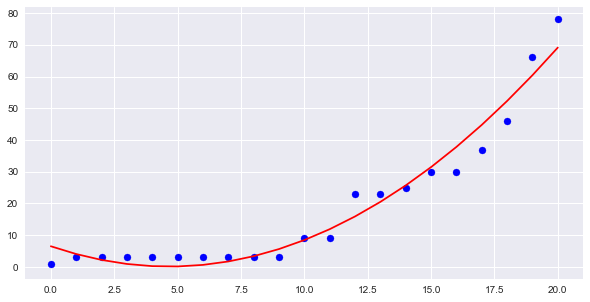

In [26]:
plt.figure(figsize=(10,5))
plt.scatter(X_train_cum,y_train_cum, color ='blue')
plt.plot(X_train_cum, lin2.predict(poly.fit_transform(X_train_cum)), color ='red')

plt.show()

In [27]:
lin2.predict(poly.fit_transform(X_test_cum))

array([[ 78.41353383],
       [ 88.29254956],
       [ 98.7584475 ],
       [109.81122767],
       [121.45089007],
       [133.67743469],
       [146.49086154]])

In [28]:
cum_poly_pred_future = lin2.predict(poly.fit_transform(future_forcast))


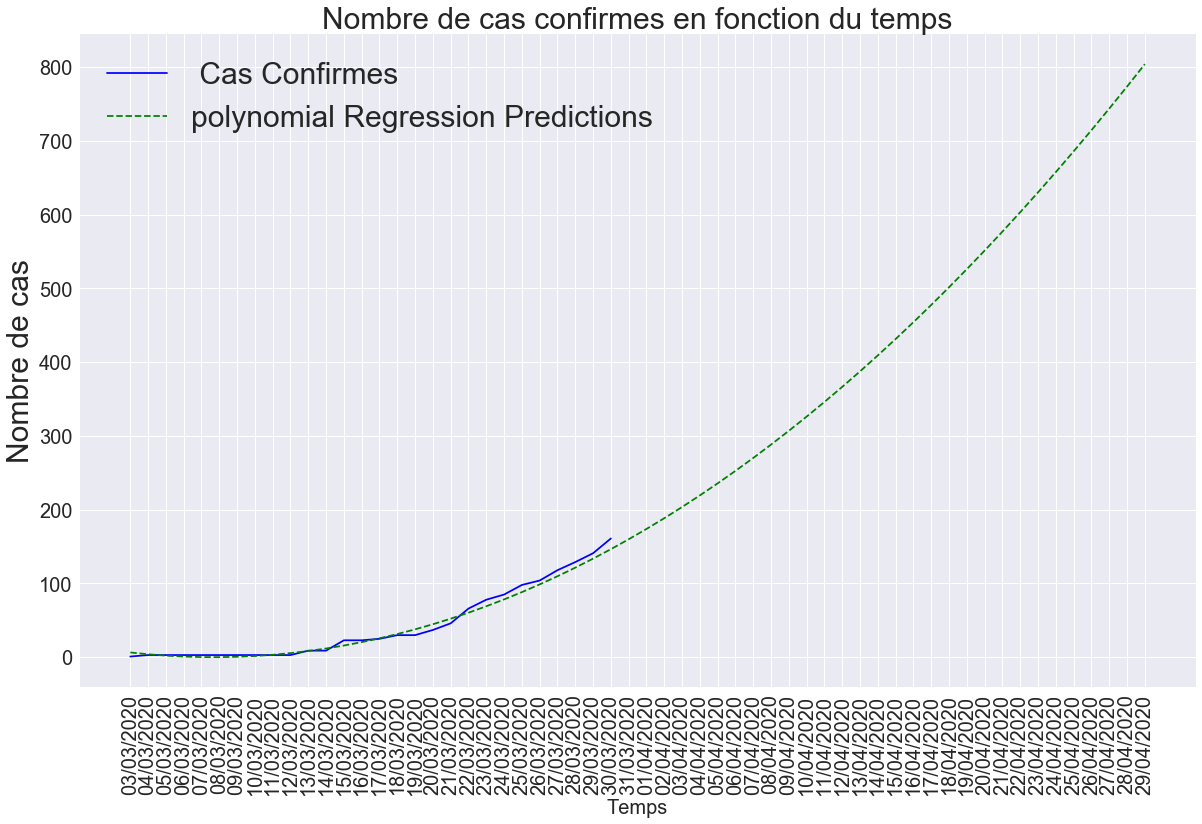

In [29]:
plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, cases_cum, color='blue')
plt.plot(future_forcast_dates, cum_poly_pred_future, linestyle='dashed', color='green')
plt.title('Nombre de cas confirmes en fonction du temps', size=30)
plt.xlabel('Temps', size=20)
plt.ylabel('Nombre de cas', size=30)
plt.legend([' Cas Confirmes', 'polynomial Regression Predictions'], prop={'size': 30})
plt.xticks(size=20, rotation = 90)
plt.yticks(size=20)
plt.show()

# Modeling Logistic Growth

Reference

https://jooskorstanje.com/modeling-logistic-growth-corona.html
https://towardsdatascience.com/modeling-exponential-growth-49a2b6f22e1f
https://towardsdatascience.com/modeling-exponential-growth-49a2b6f22e1f
https://towardsdatascience.com/modeling-logistic-growth-1367dc971de2


La croissance logistique est une fonction mathématique qui peut être utilisée dans plusieurs situations. La croissance logistique se caractérise par une croissance croissante au début, mais une croissance décroissante à un stade ultérieur, à mesure que l'on se rapproche d'un maximum. Par exemple, dans le cas du coronavirus, cette limite maximale serait le nombre total de personnes dans le monde, car lorsque tout le monde est malade, la croissance diminuera nécessairement.
Dans d'autres cas d'utilisation de croissance logistique, ce nombre pourrait être la taille d'une population animale qui croît de façon exponentielle jusqu'au moment où leur environnement ne fournit pas suffisamment de nourriture pour tous les animaux et donc la croissance devient plus lente jusqu'à ce qu'une capacité maximale de l'environnement soit atteinte .
La raison d'utiliser la croissance logistique pour modéliser l'épidémie de coronavirus est que les épidémiologistes ont étudié ces types d'épidémies et il est bien connu que la première période d'une épidémie suit la croissance exponentielle et que la période totale peut être modélisée avec une croissance logistique.

In [40]:
# Define funcion with the coefficients to estimate
def my_logistic(t, a, b, c):
    return c / (1 + a * np.exp(-b*t))

In [41]:
# Randomly initialize the coefficients
p0 = np.random.exponential(size=3)
p0

array([0.47772951, 1.26242023, 3.14659835])

In [42]:
# Set min bound 0 on all coefficients, and set different max bounds for each coefficient
bounds = (0, [100, 3., 1000])

In [43]:
data_cum
data = data_cum.reset_index(drop=False)
data= data.reset_index(drop=False)


In [44]:
data = data[['index', 'Daily_case']]

data.columns = ['Timestep', 'Total Cases']

In [48]:
# Convert pd.Series to np.Array and use Scipy's curve fit to find the best Nonlinear Least Squares coefficients
x = np.array(data['Timestep']) + 1
y = np.array(data['Total Cases'])

(a,b,c),cov = optim.curve_fit(my_logistic, x, y, bounds=bounds, p0=p0)


In [36]:
# Show the coefficients
a,b,c

(99.99999995034352, 0.17521409797378357, 260.99737844548173)

In [37]:
# Redefine the function with the new a, b and c
def my_logistic(t):
    return c / (1 + a * np.exp(-b*t))

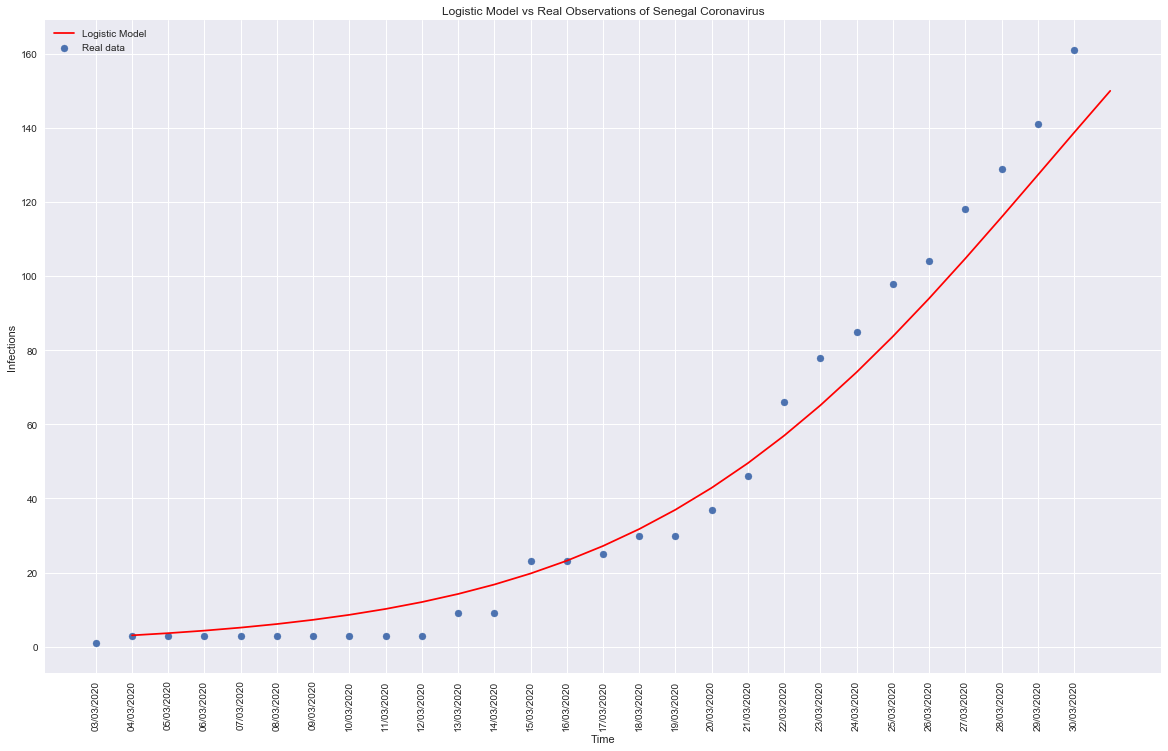

In [38]:
plt.figure(figsize=(20,12))
plt.scatter(future_forcast_dates[0:len(y)], y)
plt.plot(x, my_logistic(x),color = 'red')
plt.title('Logistic Model vs Real Observations of Senegal Coronavirus')
plt.legend([ 'Logistic Model', 'Real data'])
plt.xlabel('Time')
plt.ylabel('Infections')
plt.xticks(rotation = 90)
plt.show()

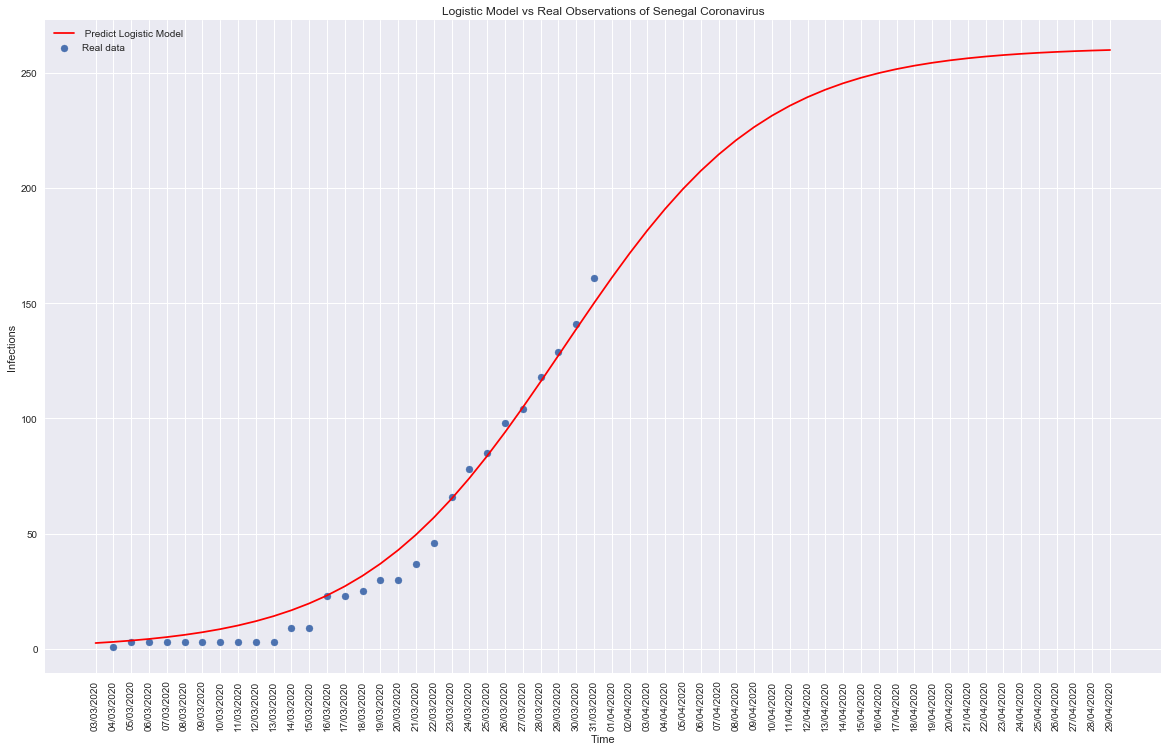

In [39]:
plt.figure(figsize=(20,12))
plt.scatter(x, y)
plt.plot(future_forcast_dates, my_logistic(future_forcast),color = 'red')
plt.title('Logistic Model vs Real Observations of Senegal Coronavirus')
plt.legend([ ' Predict Logistic Model ', 'Real data'])
plt.xlabel('Time')
plt.ylabel('Infections')
plt.xticks(rotation = 90)
plt.show()

Calcul du moment de croissance rapide

In [40]:
# The time step at which the growth is fastest
t_fastest = np.log(a) / b
t_fastest
print(np.round(t_fastest))
future_forcast_dates[27]

26.0


'30/03/2020'

In [41]:
# First way to find the y of the fastest growth moment
y_fastest = c / 2
y_fastest

130.49868922274086

In [42]:
# Second way to find the y of the fastest growth moment
my_logistic(t_fastest)

130.49868922274086